In [25]:
!pip install pandas torch scikit-learn matplotlib tqdm

In [48]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn



In [49]:
# Preprocess CSV Data for Binary Classification
def preprocess_binary_csv(csv_path, n_support, n_query):
    """
    Preprocess CSV data into support and query sets for binary classification.
    """
    df = pd.read_csv(csv_path)

    # Ensure all features are numeric and handle missing data
    feature_columns = df.columns[:-1]  # Exclude 'Label'
    df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors="coerce")
    df = df.dropna()  # Drop rows with NaN values

    # Separate the two classes: attack (1) and normal (0)
    attack_data = df[df["Label"] == 1]
    normal_data = df[df["Label"] == 0]

    print(f"Attack Samples: {len(attack_data)}")
    print(f"Normal Samples: {len(normal_data)}")

    # Split each class into support and query sets, ensuring we don't exceed available samples
    attack_support, attack_query = train_test_split(attack_data, test_size=0.6, random_state=42)  # Change test_size to 0.6
    normal_support, normal_query = train_test_split(normal_data, test_size=0.6, random_state=42)  # Change test_size to 0.6

    # Ensure the appropriate number of samples for support and query sets
    attack_support = attack_support[:n_support]
    normal_support = normal_support[:n_support]
    attack_query = attack_query[:n_query]
    normal_query = normal_query[:n_query]

    # Combine the support and query sets for both classes
    support_set = pd.concat([attack_support, normal_support])
    query_set = pd.concat([attack_query, normal_query])

    # Convert to PyTorch tensors
    support_x = torch.tensor(support_set.iloc[:, :-1].values, dtype=torch.float32)  # Exclude 'Label'
    support_y = torch.tensor(support_set["Label"].values, dtype=torch.int64)

    query_x = torch.tensor(query_set.iloc[:, :-1].values, dtype=torch.float32)
    query_y = torch.tensor(query_set["Label"].values, dtype=torch.int64)

    return support_x, support_y, query_x, query_y

In [50]:
# Prototypical Network (ProtoNet)
class ProtoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(ProtoNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def set_forward_loss(self, support_x, support_y, query_x, query_y):
        support_embed = self.forward(support_x)
        query_embed = self.forward(query_x)

        prototypes = self.compute_prototypes(support_embed, support_y)
        distances = self.compute_distances(query_embed, prototypes)

        loss = nn.CrossEntropyLoss()(distances, query_y)
        accuracy = (distances.argmax(dim=1) == query_y).float().mean()

        return loss, accuracy

    def compute_prototypes(self, support_embed, support_y):
        unique_labels = torch.unique(support_y)
        prototypes = []
        for label in unique_labels:
            class_embed = support_embed[support_y == label]
            prototypes.append(class_embed.mean(dim=0))
        return torch.stack(prototypes)

    def compute_distances(self, query_embed, prototypes):
        distances = torch.cdist(query_embed, prototypes)
        return distances

In [51]:
# Training Function
def train(model, optimizer, support_x, support_y, query_x, query_y, n_way, n_support, n_query, max_epoch, epoch_size):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0
    prev_epoch_loss = float("inf")

    while epoch < max_epoch:
        running_loss = 0.0
        running_acc = 0.0
        for _ in tqdm(range(epoch_size), desc=f"Epoch {epoch + 1} train"):
            loss, output = model.set_forward_loss(support_x, support_y, query_x, query_y)
            running_loss += loss.item()
            running_acc += output.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print(f"Epoch {epoch + 1} -- Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        if epoch_loss < prev_epoch_loss:
            torch.save(model.state_dict(), f"protonet_epoch_{epoch}.pth")
            prev_epoch_loss = epoch_loss

        epoch += 1
        scheduler.step()


In [53]:
# Main Script
if __name__ == "__main__":
    csv_path = "Modified_dataset.csv"  # Your dataset file name
    n_support = 2  # Number of support samples per class (adjust based on dataset size)
    n_query = 3    # Number of query samples per class
    max_epoch = 25
    epoch_size = 50  # Number of episodes per epoch

    # Load and preprocess the dataset
    support_x, support_y, query_x, query_y = preprocess_binary_csv(csv_path, n_support, n_query)

    # Model setup
    model = ProtoNet(
        input_dim=support_x.shape[1],  # Number of features
        hidden_dim=64,
        z_dim=256
    ).to("cuda:0" if torch.cuda.is_available() else "cpu")

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train(model, optimizer, support_x, support_y, query_x, query_y, n_way=2, n_support=n_support, n_query=n_query, max_epoch=max_epoch, epoch_size=epoch_size)
    print("Training complete.")

Attack Samples: 0
Normal Samples: 0


ValueError: With n_samples=0, test_size=0.6 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [58]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm

# Preprocessing Function
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

def preprocess_binary_csv(csv_path, n_support, n_query):
    """
    Preprocess CSV data into support and query sets for binary classification.
    """
    df = pd.read_csv(csv_path)

    # Clean column names (remove extra spaces if any)
    df.columns = df.columns.str.strip()

    # Ensure all features are numeric and handle missing data
    # Exclude 'Attack Type' and 'Label' columns from the features
    feature_columns = df.columns.difference(['Label', 'Attack Type'])

    # Convert all feature columns to numeric, coercing errors (non-numeric values to NaN)
    df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows with NaN values in the feature columns
    df = df.dropna(subset=feature_columns)

    # Separate the two classes: attack (1) and normal (0)
    attack_data = df[df["Label"] == 1]
    normal_data = df[df["Label"] == 0]

    print(f"Attack Samples: {len(attack_data)}")
    print(f"Normal Samples: {len(normal_data)}")

    # Ensure we have enough samples for both support and query sets
    if len(attack_data) < n_support + n_query or len(normal_data) < n_support + n_query:
        raise ValueError("Not enough samples in one or more classes to split into support and query sets.")

    # Split each class into support and query sets (adjust the ratio if needed)
    attack_support, attack_query = train_test_split(attack_data, test_size=0.6, random_state=42)  # 60% for query
    normal_support, normal_query = train_test_split(normal_data, test_size=0.6, random_state=42)  # 60% for query

    # Ensure the appropriate number of samples for support and query sets
    attack_support = attack_support[:n_support]
    normal_support = normal_support[:n_support]
    attack_query = attack_query[:n_query]
    normal_query = normal_query[:n_query]

    # Combine the support and query sets for both classes
    support_set = pd.concat([attack_support, normal_support])
    query_set = pd.concat([attack_query, normal_query])

    # Convert to PyTorch tensors
    support_x = torch.tensor(support_set[feature_columns].values, dtype=torch.float32)  # Only numeric columns
    support_y = torch.tensor(support_set["Label"].values, dtype=torch.int64)

    query_x = torch.tensor(query_set[feature_columns].values, dtype=torch.float32)
    query_y = torch.tensor(query_set["Label"].values, dtype=torch.int64)

    return support_x, support_y, query_x, query_y



# Prototypical Network (ProtoNet)
class ProtoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(ProtoNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def set_forward_loss(self, support_x, support_y, query_x, query_y):
        # Forward pass for support set and query set
        support_embed = self.forward(support_x)
        query_embed = self.forward(query_x)

        # Calculate prototypes
        prototypes = self.compute_prototypes(support_embed, support_y)

        # Calculate distances between query points and prototypes
        distances = self.compute_distances(query_embed, prototypes)

        # Compute loss (Cross-Entropy)
        loss = nn.CrossEntropyLoss()(distances, query_y)
        accuracy = (distances.argmax(dim=1) == query_y).float().mean()

        return loss, accuracy

    def compute_prototypes(self, support_embed, support_y):
        # Compute prototypes by averaging embeddings for each class
        unique_labels = torch.unique(support_y)
        prototypes = []
        for label in unique_labels:
            class_embed = support_embed[support_y == label]
            prototypes.append(class_embed.mean(dim=0))
        return torch.stack(prototypes)

    def compute_distances(self, query_embed, prototypes):
        # Calculate Euclidean distances between query embeddings and class prototypes
        distances = torch.cdist(query_embed, prototypes)
        return distances


# Training Function
def train(model, optimizer, support_x, support_y, query_x, query_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Train the Prototypical Network.
    """
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0
    prev_epoch_loss = float("inf")

    while epoch < max_epoch:
        running_loss = 0.0
        running_acc = 0.0
        for _ in tqdm(range(epoch_size), desc=f"Epoch {epoch + 1} train"):
            loss, output = model.set_forward_loss(support_x, support_y, query_x, query_y)
            running_loss += loss.item()
            running_acc += output.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print(f"Epoch {epoch + 1} -- Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        if epoch_loss < prev_epoch_loss:
            torch.save(model.state_dict(), f"protonet_epoch_{epoch}.pth")
            prev_epoch_loss = epoch_loss

        epoch += 1
        scheduler.step()


# Main Script
if __name__ == "__main__":
    csv_path = "Modified_dataset.csv"  # Your dataset file name
    n_support = 2  # Number of support samples per class (adjust based on dataset size)
    n_query = 3    # Number of query samples per class
    max_epoch = 25
    epoch_size = 50  # Number of episodes per epoch

    # Load and preprocess the dataset
    support_x, support_y, query_x, query_y = preprocess_binary_csv(csv_path, n_support, n_query)

    # Model setup
    model = ProtoNet(
        input_dim=support_x.shape[1],  # Number of features
        hidden_dim=64,
        z_dim=256
    ).to("cuda:0" if torch.cuda.is_available() else "cpu")

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=\.001)


    # Train the model
    train(model, optimizer, support_x, support_y, query_x, query_y, n_way=2, n_support=n_support, n_query=n_query, max_epoch=max_epoch, epoch_size=epoch_size)
    print("Training complete.")

Attack Samples: 140
Normal Samples: 139


Epoch 1 train: 100%|██████████| 50/50 [00:00<00:00, 233.02it/s]


Epoch 1 -- Loss: 5371651.0897, Accuracy: 0.5500


Epoch 2 train: 100%|██████████| 50/50 [00:00<00:00, 596.22it/s]


Epoch 2 -- Loss: 44779.9426, Accuracy: 0.6833


Epoch 3 train: 100%|██████████| 50/50 [00:00<00:00, 683.31it/s]


Epoch 3 -- Loss: 13168.7842, Accuracy: 0.7733


Epoch 4 train: 100%|██████████| 50/50 [00:00<00:00, 595.30it/s]


Epoch 4 -- Loss: 5644.9492, Accuracy: 0.8067


Epoch 5 train: 100%|██████████| 50/50 [00:00<00:00, 579.85it/s]


Epoch 5 -- Loss: 3216.0650, Accuracy: 0.8333


Epoch 6 train: 100%|██████████| 50/50 [00:00<00:00, 675.04it/s]


Epoch 6 -- Loss: 395.9683, Accuracy: 0.9200


Epoch 7 train: 100%|██████████| 50/50 [00:00<00:00, 583.06it/s]


Epoch 7 -- Loss: 15.3358, Accuracy: 0.9767


Epoch 8 train: 100%|██████████| 50/50 [00:00<00:00, 579.41it/s]


Epoch 8 -- Loss: 2.5933, Accuracy: 0.9933


Epoch 9 train: 100%|██████████| 50/50 [00:00<00:00, 629.37it/s]


Epoch 9 -- Loss: 0.4533, Accuracy: 0.9967


Epoch 10 train: 100%|██████████| 50/50 [00:00<00:00, 625.52it/s]


Epoch 10 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 11 train: 100%|██████████| 50/50 [00:00<00:00, 363.62it/s]


Epoch 11 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 12 train: 100%|██████████| 50/50 [00:00<00:00, 478.58it/s]


Epoch 12 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 13 train: 100%|██████████| 50/50 [00:00<00:00, 558.76it/s]


Epoch 13 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 14 train: 100%|██████████| 50/50 [00:00<00:00, 683.91it/s]


Epoch 14 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 15 train: 100%|██████████| 50/50 [00:00<00:00, 633.12it/s]


Epoch 15 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 16 train: 100%|██████████| 50/50 [00:00<00:00, 486.27it/s]


Epoch 16 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 17 train: 100%|██████████| 50/50 [00:00<00:00, 652.52it/s]


Epoch 17 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 18 train: 100%|██████████| 50/50 [00:00<00:00, 578.45it/s]


Epoch 18 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 19 train: 100%|██████████| 50/50 [00:00<00:00, 641.94it/s]


Epoch 19 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 20 train: 100%|██████████| 50/50 [00:00<00:00, 635.49it/s]


Epoch 20 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 21 train: 100%|██████████| 50/50 [00:00<00:00, 501.20it/s]


Epoch 21 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 22 train: 100%|██████████| 50/50 [00:00<00:00, 497.53it/s]


Epoch 22 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 23 train: 100%|██████████| 50/50 [00:00<00:00, 424.78it/s]


Epoch 23 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 24 train: 100%|██████████| 50/50 [00:00<00:00, 418.27it/s]


Epoch 24 -- Loss: 0.0000, Accuracy: 1.0000


Epoch 25 train: 100%|██████████| 50/50 [00:00<00:00, 421.53it/s]

Epoch 25 -- Loss: 0.0000, Accuracy: 1.0000
Training complete.


In [59]:
torch.save(model.state_dict(), "protonet_final_model.pth")
print("Model saved successfully!")

Model saved successfully!


In [61]:
model.load_state_dict(torch.load("protonet_final_model.pth"))  # Load the best model
model.eval()  # Set the model to evaluation mode


ProtoNet(
  (fc1): Linear(in_features=78, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=256, bias=True)
)

In [62]:
def evaluate_model(model, query_x, query_y):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients during evaluation
        # Forward pass
        query_embed = model(query_x)

        # Compute prototypes from query labels
        unique_labels = torch.unique(query_y)
        prototypes = []
        for label in unique_labels:
            class_embed = query_embed[query_y == label]
            prototypes.append(class_embed.mean(dim=0))
        prototypes = torch.stack(prototypes)

        # Calculate distances between query embeddings and prototypes
        distances = torch.cdist(query_embed, prototypes)
        # Get the predicted class (class with the minimum distance)
        predictions = distances.argmin(dim=1)

        # Calculate accuracy
        accuracy = (predictions == query_y).float().mean()
        return accuracy.item()

# Evaluate on the query set
accuracy = evaluate_model(model, query_x, query_y)
print(f"Model Accuracy on Query Set: {accuracy * 100:.2f}%")


Model Accuracy on Query Set: 66.67%


In [66]:
import matplotlib.pyplot as plt

def plot_training_results(acc_loss_df):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(acc_loss_df["epoch"], acc_loss_df["loss"], label="Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(acc_loss_df["epoch"], acc_loss_df["accuracy"], label="Accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

# Assuming acc_loss_df contains the epoch-wise results
plot_training_results(acc_loss_df)


NameError: name 'acc_loss_df' is not defined

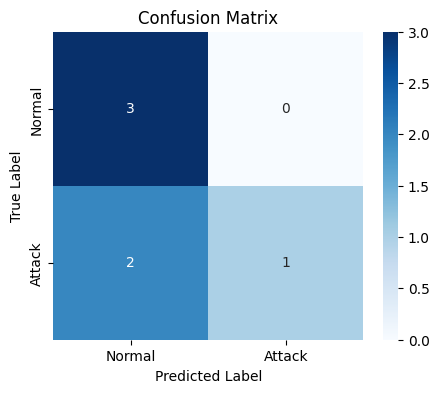

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(query_y, predictions):
    cm = confusion_matrix(query_y, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Generate predictions on query set
with torch.no_grad():
    query_embed = model(query_x)
    unique_labels = torch.unique(query_y)
    prototypes = []
    for label in unique_labels:
        class_embed = query_embed[query_y == label]
        prototypes.append(class_embed.mean(dim=0))
    prototypes = torch.stack(prototypes)
    distances = torch.cdist(query_embed, prototypes)
    predictions = distances.argmin(dim=1)

# Plot confusion matrix
plot_confusion_matrix(query_y, predictions)


In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(query_y, predictions)
recall = recall_score(query_y, predictions)
f1 = f1_score(query_y, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 1.0000
Recall: 0.3333
F1-Score: 0.5000
